## **Notebook containing scripts and outputs of the training, cross-validation and empirical data prediction for *Pilosocereus aurisetus***
From the manuscript Perez et al. "Species Delimitation Meets Deep Learning: Insights from a Highly Fragmented Cactus System"


In [ ]:
#mount google drive to load files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import all required modules.
import sys, os
import numpy as np
import keras
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers.merge import concatenate
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import  AveragePooling1D
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.neighbors import NearestNeighbors
from random import shuffle
import time

# Define parameters for the CNN run.
batch_size = 250
epochs = 250
num_classes = 7

# Define the CNN architecture.
def create_cnn(xtest, regularizer=None):
	inputShape = (xtest.shape[1], xtest.shape[2])
	inputs = Input(shape=inputShape)
	x = inputs
	x = Conv1D(250, kernel_size=2, activation='relu',input_shape=(xtest.shape[1], xtest.shape[2]))(x)
	x = Conv1D(125, kernel_size=2, activation='relu')(x)
	x = AveragePooling1D(pool_size=2)(x)
	x = Dropout(0.75)(x)
	x = Conv1D(125, kernel_size=2, activation='relu')(x)
	x = AveragePooling1D(pool_size=2)(x)
	x = Dropout(0.75)(x)
	x = Flatten()(x)
	x = Dense(125, activation='relu')(x)
	x = Dropout(0.5)(x)
	x = Dense(125, activation='relu')(x)
	x = Dropout(0.5)(x)
  # The final fully-connected layer head will have a softmax dense layer.
	x = Dense(num_classes, activation="softmax")(x)

	# Construct the CNN.
	model = Model(inputs, x)
	# Return the CNN.
	return model

# **Train the network with 10,000 simulations from each model**
Here we will use the full simulated dataset to train the network, by splitting the data with 75% of simulations for training and 25% for validation.



In [ ]:
!unzip "/content/drive/My Drive/Colab Notebooks/CNN_SpDelimitation_Piloso/trainingSims/Piloso/training10ksims.zip"

Archive:  /content/drive/My Drive/Colab Notebooks/CNN_SpDelimitation_Piloso/trainingSims/Piloso/training10ksims.zip
  inflating: simModel1.npy           
  inflating: simModel2.npy           
  inflating: simModel3.npy           
  inflating: simModel4.npy           
  inflating: simModel5.npy           
  inflating: simModel6.npy           
  inflating: simModel7.npy           


In [ ]:
################################################################################################################################################
#Train a network using 10K simulations per model.
################################################################################################################################################
# Load Numpy arrays containing simulations.
u1 = np.load("/content/simModel1.npy",mmap_mode='r')
u2 = np.load("/content/simModel2.npy",mmap_mode='r')
u3 = np.load("/content/simModel3.npy",mmap_mode='r')
u4 = np.load("/content/simModel4.npy",mmap_mode='r')
u5 = np.load("/content/simModel5.npy",mmap_mode='r')
u6 = np.load("/content/simModel6.npy",mmap_mode='r')
u7 = np.load("/content/simModel7.npy",mmap_mode='r')

# Combine all arrays.
x=np.concatenate((u1,u2,u3,u4,u5,u6,u7),axis=0)

# Label each simulated array.
y=[0 for i in range(len(u1))]
y.extend([1 for i in range(len(u2))])
y.extend([2 for i in range(len(u3))])
y.extend([3 for i in range(len(u4))])
y.extend([4 for i in range(len(u5))])
y.extend([5 for i in range(len(u6))])
y.extend([6 for i in range(len(u7))])
y = np.array(y)

for arr,array in enumerate(x):
  for idx,row in enumerate(array):
    if np.count_nonzero(row) > len(row)/2:
      x[arr][idx][x[arr][idx] == 0] = -1
      x[arr][idx][x[arr][idx] == 1] = 0
      x[arr][idx][x[arr][idx] == -1] = 1

x=x.astype(np.uint8)

# Print label and simulations length, these should be the same.
print (len(x), len(y))

# Shuffle the arrays for training, keeping the labels in the same order.
shf = list(range(len(x)))
shuffle(shf)
y = y[shf]
x = x[shf]

# Separate train (75%) and validate (25%) sets.
xtrain, xtest = x[int(len(y)*.25):], x[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
del(x)
ytest = keras.utils.to_categorical(ytest, num_classes)
ytrain = keras.utils.to_categorical(ytrain, num_classes)

# Create the CNN network, using the architecture defined above.
cnn = create_cnn(xtest)

# Compile the CNN.
cnn.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=keras.optimizers.Adam(),
	              metrics=['accuracy'])
print(cnn.summary())

# Run the CNN and save the model with the best val_accuracy. Record the runtime required to train the network
mcp_save = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/CNN_SpDelimitation_Piloso/Trained_10KSims.acc.mod', save_best_only=True, monitor='val_accuracy', mode='max')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=20, verbose=1, mode='max')
start = time.time()
cnn.fit(xtrain, ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(xtest, ytest),callbacks=[mcp_save,reduce_lr_loss])
print (f'Time: {time.time() - start}')

70000 70000
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 195, 64)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 194, 250)          32250     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 193, 125)          62625     
_________________________________________________________________
average_pooling1d (AveragePo (None, 96, 125)           0         
_________________________________________________________________
dropout (Dropout)            (None, 96, 125)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 95, 125)           31375     
_________________________________________________________________
average_pooling1d_1 (Average (None, 47, 125)     

In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/CNN_SpDelimitation_Piloso/TestData/Piloso/test1ksims.zip"

Archive:  /content/drive/MyDrive/Colab Notebooks/CNN_SpDelimitation_Piloso/TestData/Piloso/test1ksims.zip
replace simModel1.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: simModel1.npy           
replace simModel2.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: simModel2.npy           
replace simModel3.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: simModel3.npy           
replace simModel4.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: simModel4.npy           
replace simModel5.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: simModel5.npy           
replace simModel6.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: simModel6.npy           
replace simModel7.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: simModel7.npy           


In [ ]:
################################################################################################################################################
#Evaluate the CNN trained with 10K simulations per model, using 1,000 simulations per model as test set.
################################################################################################################################################
# Load Numpy arrays containing test set simulations.
t1 = np.load("/content/simModel1.npy",mmap_mode='r')
t2 = np.load("/content/simModel2.npy",mmap_mode='r')
t3 = np.load("/content/simModel3.npy",mmap_mode='r')
t4 = np.load("/content/simModel4.npy",mmap_mode='r')
t5 = np.load("/content/simModel5.npy",mmap_mode='r')
t6 = np.load("/content/simModel6.npy",mmap_mode='r')
t7 = np.load("/content/simModel7.npy",mmap_mode='r')
t=np.concatenate((t1,t2,t3,t4,t5,t6,t7),axis=0)

for arr,array in enumerate(t):
  for idx,row in enumerate(array):
    if np.count_nonzero(row) > len(row)/2:
      t[arr][idx][t[arr][idx] == 0] = -1
      t[arr][idx][t[arr][idx] == 1] = 0
      t[arr][idx][t[arr][idx] == -1] = 1

t=t.astype(np.uint8)

# Label simulations from the test set.
y=[0 for i in range(len(t1))]
y.extend([1 for i in range(len(t2))])
y.extend([2 for i in range(len(t3))])
y.extend([3 for i in range(len(t4))])
y.extend([4 for i in range(len(t5))])
y.extend([5 for i in range(len(t6))])
y.extend([6 for i in range(len(t7))])
y = np.array(y)

# Load the trained model.
from keras.models import load_model
from sklearn.metrics import confusion_matrix
model = load_model('/content/drive/My Drive/Colab Notebooks/CNN_SpDelimitation_Piloso/Trained_10KSims.acc.mod')

# Predict and export a confusion matrix.
pred = model.predict(t)
pred_cat = [i.argmax() for i in pred]
print (confusion_matrix(y, pred_cat))

[[876   0  18   0   0 106   0]
 [  2 824   0   9   5   0 160]
 [  0   0 998   2   0   0   0]
 [  0   1  46 929  23   0   1]
 [  0   1   0   1 997   0   1]
 [ 48   0  18   0   0 934   0]
 [  0  22   2  16   4   1 955]]


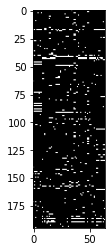

In [ ]:
################################################################################################################################################
#Predict the most likely model for the empirical data, using the CNN trained with 10K simulations per model.
################################################################################################################################################
# Load the trained network.
model = load_model('/content/drive/My Drive/Colab Notebooks/CNN_SpDelimitation_Piloso/Trained_10KSims.acc.mod')
# Load empirical data and transpose it.
infile=np.loadtxt("/content/drive/MyDrive/Colab Notebooks/CNN_SpDelimitation_Piloso/Input_Piloso.txt")
inp=[]
inp.append(np.array(infile).T)
inp = np.array(inp)

for idx,row in enumerate(inp[0]):
  if np.count_nonzero(row) > len(row)/2:
    inp[0][idx][inp[0][idx] == 0] = -1
    inp[0][idx][inp[0][idx] == 1] = 0
    inp[0][idx][inp[0][idx] == -1] = 1

inp=inp.astype(np.uint8)

#Export an image from the empirical data, to visualize its appearance
import matplotlib.pyplot as plt
plt.imshow(inp[0],cmap='gray', vmin=0, vmax=1)

In [ ]:
t1 = np.load("/content/simModel1.npy",mmap_mode='r')
t2 = np.load("/content/simModel2.npy",mmap_mode='r')
t3 = np.load("/content/simModel3.npy",mmap_mode='r')
t4 = np.load("/content/simModel4.npy",mmap_mode='r')
t5 = np.load("/content/simModel5.npy",mmap_mode='r')
t6 = np.load("/content/simModel6.npy",mmap_mode='r')
t7 = np.load("/content/simModel7.npy",mmap_mode='r')
t=np.concatenate((t1,t2,t3,t4,t5,t6,t7),axis=0)

for arr,array in enumerate(t):
  for idx,row in enumerate(array):
    if np.count_nonzero(row) > len(row)/2:
      t[arr][idx][t[arr][idx] == 0] = -1
      t[arr][idx][t[arr][idx] == 1] = 0
      t[arr][idx][t[arr][idx] == -1] = 1

t=t.astype(np.uint8)

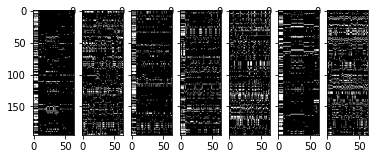

In [ ]:
#now plot one image from each model to see their appearance
f, axarr = plt.subplots(1,7) 
#model 1
#ax.set_title(str("model 1")
axarr[0].imshow(t[0],cmap='gray', vmin=0, vmax=1)
axarr[1].imshow(t[1000],cmap='gray', vmin=0, vmax=1)
axarr[2].imshow(t[2000],cmap='gray', vmin=0, vmax=1)
axarr[3].imshow(t[3000],cmap='gray', vmin=0, vmax=1)
axarr[4].imshow(t[4000],cmap='gray', vmin=0, vmax=1)
axarr[5].imshow(t[5000],cmap='gray', vmin=0, vmax=1)
axarr[6].imshow(t[6000],cmap='gray', vmin=0, vmax=1)

In [ ]:
# Predict the most likely model with the empirical data.
pred = model.predict(inp)
print(pred)

#Repeat the predictions more 4 times after shuffling the order of rows (SNPs)
#shuffle rows
perm = np.arange(inp.shape[0])
np.random.shuffle(perm)
inp = inp[perm]

#and predict
pred = model.predict(inp)
print(pred)

#shuffle rows
perm = np.arange(inp.shape[0])
np.random.shuffle(perm)
inp = inp[perm]

#and predict
pred = model.predict(inp)
print(pred)

#shuffle rows
perm = np.arange(inp.shape[0])
np.random.shuffle(perm)
inp = inp[perm]

#and predict
pred = model.predict(inp)
print(pred)

#shuffle rows
perm = np.arange(inp.shape[0])
np.random.shuffle(perm)
inp = inp[perm]

#and predict
pred = model.predict(inp)
print(pred)

[[9.9896288e-01 1.7545807e-04 1.4069257e-09 3.3225223e-10 6.5507436e-13
  8.6170074e-04 7.3612116e-09]]
[[9.9896288e-01 1.7545807e-04 1.4069257e-09 3.3225223e-10 6.5507436e-13
  8.6170074e-04 7.3612116e-09]]
[[9.9896288e-01 1.7545807e-04 1.4069257e-09 3.3225223e-10 6.5507436e-13
  8.6170074e-04 7.3612116e-09]]
[[9.9896288e-01 1.7545807e-04 1.4069257e-09 3.3225223e-10 6.5507436e-13
  8.6170074e-04 7.3612116e-09]]
[[9.9896288e-01 1.7545807e-04 1.4069257e-09 3.3225223e-10 6.5507436e-13
  8.6170074e-04 7.3612116e-09]]


# **Evaluate the impact of using different number of simulations to train the network**
Below, we repeat the procedures of training and evalutating the CNN, with varying number of simulations (2,500; 1,000 and 500) per model.

In [ ]:
################################################################################################################################################
#Train the network with 2.5K simulations per model
################################################################################################################################################

x=np.concatenate((u1[0:2500,:,:],u2[0:2500,:,:],u3[0:2500,:,:],u4[0:2500,:,:],u5[0:2500,:,:],u6[0:2500,:,:],u7[0:2500,:,:]),axis=0)

for arr,array in enumerate(x):
  for idx,row in enumerate(array):
    if np.count_nonzero(row) > len(row)/2:
      x[arr][idx][x[arr][idx] == 0] = -1
      x[arr][idx][x[arr][idx] == 1] = 0
      x[arr][idx][x[arr][idx] == -1] = 1

x=x.astype(np.uint8)

y=[0 for i in range(len(u1[0:2500,:,:]))]
y.extend([1 for i in range(len(u2[0:2500,:,:]))])
y.extend([2 for i in range(len(u3[0:2500,:,:]))])
y.extend([3 for i in range(len(u4[0:2500,:,:]))])
y.extend([4 for i in range(len(u5[0:2500,:,:]))])
y.extend([5 for i in range(len(u6[0:2500,:,:]))])
y.extend([6 for i in range(len(u7[0:2500,:,:]))])
y = np.array(y)

print (len(x), len(y))
shf = list(range(len(x)))
shuffle(shf)

y = y[shf]
x = x[shf]

xtrain, xtest = x[int(len(y)*.25):], x[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]

ytest = keras.utils.to_categorical(ytest, num_classes)
ytrain = keras.utils.to_categorical(ytrain, num_classes)

# Create the CNN network
cnn = create_cnn(xtest)

cnn.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=keras.optimizers.Adam(),
	              metrics=['accuracy'])

print(cnn.summary())

# Run the CNN and save the model with the best val_accuracy. Record the runtime required to train the network
mcp_save = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/CNN_SpDelimitation_Piloso/Trained_2.5KSims.acc.mod', save_best_only=True, monitor='val_accuracy', mode='max')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=20, verbose=1, mode='max')
start = time.time()
cnn.fit(xtrain, ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(xtest, ytest),callbacks=[mcp_save,reduce_lr_loss])
print (f'Time: {time.time() - start}')

17500 17500
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 195, 64)]         0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 194, 250)          32250     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 193, 125)          62625     
_________________________________________________________________
average_pooling1d_2 (Average (None, 96, 125)           0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 96, 125)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 95, 125)           31375     
_________________________________________________________________
average_pooling1d_3 (Average (None, 47, 125)   

In [ ]:
################################################################################################################################################
#Train the network with 1K simulations per model
################################################################################################################################################

x=np.concatenate((u1[0:1000,:,:],u2[0:1000,:,:],u3[0:1000,:,:],u4[0:1000,:,:],u5[0:1000,:,:],u6[0:1000,:,:],u7[0:1000,:,:]),axis=0)

for arr,array in enumerate(x):
  for idx,row in enumerate(array):
    if np.count_nonzero(row) > len(row)/2:
      x[arr][idx][x[arr][idx] == 0] = -1
      x[arr][idx][x[arr][idx] == 1] = 0
      x[arr][idx][x[arr][idx] == -1] = 1

y=[0 for i in range(len(u1[0:1000,:,:]))]
y.extend([1 for i in range(len(u2[0:1000,:,:]))])
y.extend([2 for i in range(len(u3[0:1000,:,:]))])
y.extend([3 for i in range(len(u4[0:1000,:,:]))])
y.extend([4 for i in range(len(u5[0:1000,:,:]))])
y.extend([5 for i in range(len(u6[0:1000,:,:]))])
y.extend([6 for i in range(len(u7[0:1000,:,:]))])
y = np.array(y)

print (len(x), len(y))
shf = list(range(len(x)))
shuffle(shf)

y = y[shf]
x = x[shf]

xtrain, xtest = x[int(len(y)*.25):], x[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]

ytest = keras.utils.to_categorical(ytest, num_classes)
ytrain = keras.utils.to_categorical(ytrain, num_classes)

# Create the CNN network
cnn = create_cnn(xtest)


cnn.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=keras.optimizers.Adam(),
	              metrics=['accuracy'])

print(cnn.summary())

# Run the CNN and save the model with the best val_accuracy. Record the runtime required to train the network
mcp_save = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/CNN_SpDelimitation_Piloso/Trained_1KSims.acc.mod', save_best_only=True, monitor='val_accuracy', mode='max')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=20, verbose=1, mode='max')
start = time.time()
cnn.fit(xtrain, ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(xtest, ytest),callbacks=[mcp_save,reduce_lr_loss])
print (f'Time: {time.time() - start}')

7000 7000
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 195, 64)]         0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 194, 250)          32250     
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 193, 125)          62625     
_________________________________________________________________
average_pooling1d_4 (Average (None, 96, 125)           0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 96, 125)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 95, 125)           31375     
_________________________________________________________________
average_pooling1d_5 (Average (None, 47, 125)     

In [ ]:
################################################################################################################################################
#Train the network with 500 simulations per model
################################################################################################################################################

x=np.concatenate((u1[0:500,:,:],u2[0:500,:,:],u3[0:500,:,:],u4[0:500,:,:],u5[0:500,:,:],u6[0:500,:,:],u7[0:500,:,:]),axis=0)

for arr,array in enumerate(x):
  for idx,row in enumerate(array):
    if np.count_nonzero(row) > len(row)/2:
      x[arr][idx][x[arr][idx] == 0] = -1
      x[arr][idx][x[arr][idx] == 1] = 0
      x[arr][idx][x[arr][idx] == -1] = 1

x=x.astype(np.uint8)

y=[0 for i in range(len(u1[0:500,:,:]))]
y.extend([1 for i in range(len(u2[0:500,:,:]))])
y.extend([2 for i in range(len(u3[0:500,:,:]))])
y.extend([3 for i in range(len(u4[0:500,:,:]))])
y.extend([4 for i in range(len(u5[0:500,:,:]))])
y.extend([5 for i in range(len(u6[0:500,:,:]))])
y.extend([6 for i in range(len(u7[0:500,:,:]))])
y = np.array(y)

print (len(x), len(y))
shf = list(range(len(x)))
shuffle(shf)

y = y[shf]
x = x[shf]

xtrain, xtest = x[int(len(y)*.25):], x[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]

ytest = keras.utils.to_categorical(ytest, num_classes)
ytrain = keras.utils.to_categorical(ytrain, num_classes)

# Create the CNN network
cnn = create_cnn(xtest)

cnn.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=keras.optimizers.Adam(),
	              metrics=['accuracy'])

print(cnn.summary())

# Run the CNN and save the model with the best val_accuracy. Record the runtime required to train the network
mcp_save = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/CNN_SpDelimitation_Piloso/Trained_0.5KSims.acc.mod', save_best_only=True, monitor='val_accuracy', mode='max')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=20, verbose=1, mode='max')
start = time.time()
cnn.fit(xtrain, ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(xtest, ytest),callbacks=[mcp_save,reduce_lr_loss])
print (f'Time: {time.time() - start}')

3500 3500
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 195, 64)]         0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 194, 250)          32250     
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 193, 125)          62625     
_________________________________________________________________
average_pooling1d_6 (Average (None, 96, 125)           0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 96, 125)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 95, 125)           31375     
_________________________________________________________________
average_pooling1d_7 (Average (None, 47, 125)     

In [ ]:
################################################################################################################################################
#Evaluate the CNN trained with 2.5K simulations per model, using 1,000 simulations per model as test set.
################################################################################################################################################

t=np.concatenate((t1,t2,t3,t4,t5,t6,t7),axis=0)

for arr,array in enumerate(x):
  for idx,row in enumerate(array):
    if np.count_nonzero(row) > len(row)/2:
      t[arr][idx][t[arr][idx] == 0] = -1
      t[arr][idx][t[arr][idx] == 1] = 0
      t[arr][idx][t[arr][idx] == -1] = 1

t=t.astype(np.uint8)

# Label simulations from the test set.
y=[0 for i in range(len(t1))]
y.extend([1 for i in range(len(t2))])
y.extend([2 for i in range(len(t3))])
y.extend([3 for i in range(len(t4))])
y.extend([4 for i in range(len(t5))])
y.extend([5 for i in range(len(t6))])
y.extend([6 for i in range(len(t7))])
y = np.array(y)

from keras.models import load_model
from sklearn.metrics import confusion_matrix

model = load_model('/content/drive/MyDrive/Colab Notebooks/CNN_SpDelimitation_Piloso/Trained_2.5KSims.acc.mod')
pred = model.predict(t)

pred_cat = [i.argmax() for i in pred]
print (confusion_matrix(y, pred_cat))

[[ 738    0   52    0    0  210    0]
 [   3  800    0   13   15    0  169]
 [   0    0 1000    0    0    0    0]
 [   0    0  107  858   34    0    1]
 [   0    1    0    6  993    0    0]
 [   9    0   44    0    0  947    0]
 [   0   60    4   20    3    6  907]]


In [ ]:
################################################################################################################################################
#Evaluate the CNN trained with 1K simulations per model, using 1,000 simulations per model as test set.
################################################################################################################################################

from keras.models import load_model
from sklearn.metrics import confusion_matrix

model = load_model('/content/drive/MyDrive/Colab Notebooks/CNN_SpDelimitation_Piloso/Trained_1KSims.acc.mod')
pred = model.predict(t)

pred_cat = [i.argmax() for i in pred]
print (confusion_matrix(y, pred_cat))

[[781   0  74   0   0 145   0]
 [  5 764   0  19  20   0 192]
 [  0   0 999   1   0   0   0]
 [  0   0 124 830  43   0   3]
 [  0   3   0   5 991   0   1]
 [ 52   0  54   0   0 894   0]
 [  1  79   3  15   6   4 892]]


In [ ]:
################################################################################################################################################
#Evaluate the CNN trained with 500 simulations per model, using 1,000 simulations per model as test set.
################################################################################################################################################
t=np.concatenate((t1,t2,t3,t4,t5,t6,t7),axis=0)

for arr,array in enumerate(x):
  for idx,row in enumerate(array):
    if np.count_nonzero(row) > len(row)/2:
      t[arr][idx][t[arr][idx] == 0] = -1
      t[arr][idx][t[arr][idx] == 1] = 0
      t[arr][idx][t[arr][idx] == -1] = 1

t=t.astype(np.uint8)

# Label simulations from the test set.
y=[0 for i in range(len(t1))]
y.extend([1 for i in range(len(t2))])
y.extend([2 for i in range(len(t3))])
y.extend([3 for i in range(len(t4))])
y.extend([4 for i in range(len(t5))])
y.extend([5 for i in range(len(t6))])
y.extend([6 for i in range(len(t7))])
y = np.array(y)

from keras.models import load_model
from sklearn.metrics import confusion_matrix

model = load_model('/content/drive/MyDrive/Colab Notebooks/CNN_SpDelimitation_Piloso/Trained_0.5KSims.acc.mod')
pred = model.predict(t)

pred_cat = [i.argmax() for i in pred]
print (confusion_matrix(y, pred_cat))

[[ 20   0  90   0   0 890   0]
 [  3 578   0  33  49   2 335]
 [  0   0 998   2   0   0   0]
 [  0   1 126 842  31   0   0]
 [  0   0   0  11 989   0   0]
 [ 21   0  71   0   0 908   0]
 [  9 353   4  23  11   6 594]]
